# Análisis de datos de películas indexados en Solr

El propósito de esta notebook es utilizar la data de películas, a la cual ya se le realizó ingeniería de atributos y se indexó en Solr, para realizar análisis. Se elaboraron una serie de reportes con el fin de generar información util para el rubro de las películas.

Se utilizó la librería pysolr para consumir los datos del core de Solr, instalar si no existe:

In [ ]:
! pip install pysolr

Conexión al indice de Solr, es necesario que el servicio Solr este iniciado en el puerto 8983

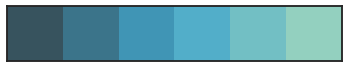

In [1]:
import pysolr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

sns.set(style="white", context="talk")
sns.palplot(sns.color_palette("GnBu_d"))

rcParams['figure.figsize'] = 11.7,11.7


solrcon = pysolr.Solr('http://192.168.56.101:8983/solr/movies_indexed', timeout=100)

In [2]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

# Obtención de Géneros (genres)

In [3]:
results = solrcon.search('*:*', fq=['revenue:[1 TO *]', 'genres:["" TO *]'], rows=50000)
movies_with_revenue_query = pd.DataFrame(results.docs)
print(len(movies_with_revenue_query))
movies_with_revenue_query

7354


,movie_id,adult,budget,genres,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,spoken_languages,title,rating,keywords,cast_actors,id,_version_
0,[752],[False],[54000000],"[Action, Thriller, Fantasy]",[en],[V for Vendetta],[In a world in which Great Britain has become ...,[20.214422],"[Studio Babelsberg, DC Comics, Virtual Studios...","[Germany, United Kingdom, United States of Ame...",[2006-03-15T00:00:00Z],[132511035],[English],[V for Vendetta],[3.9198477],"[detective, vatican, fascism, satanism, fascis...","[Natalie Portman, Hugo Weaving, Stephen Rea, S...",924df91f-1d12-4e0d-aff6-56a0a94ecb92,1672681000073691136
1,[767],[False],[250000000],"[Adventure, Fantasy, Family]",[en],[Harry Potter and the Half-Blood Prince],"[As Harry begins his sixth year at Hogwarts, h...",[19.083723],"[Warner Bros., Heyday Films]","[United Kingdom, United States of America]",[2009-07-07T00:00:00Z],[933959197],[English],[Harry Potter and the Half-Blood Prince],[3.8431253],"[witch, magic, broom, school of witchcraft, wi...","[Daniel Radcliffe, Rupert Grint, Emma Watson, ...",2f1ae3e3-d4a6-4fb8-8efa-1f99817b89ec,1672681000135557120
2,[790],[False],[1000000],[Horror],[en],[The Fog],[Strange things begin to occurs as a tiny Cali...,[9.194572],"[AVCO Embassy Pictures, EDI, Debra Hill Produc...",[United States of America],[1980-02-08T00:00:00Z],[21378361],[English],[The Fog],[3.0338051],"[prophecy, sea, beach, gold, small town, behea...","[Adrienne Barbeau, Jamie Lee Curtis, Janet Lei...",d39d9c98-a65d-4459-b049-bc21d6402d88,1672681000143945728
3,[1593],[False],[110000000],"[Action, Adventure, Comedy, Family, Fantasy]",[en],[Night at the Museum],[Chaos reigns at the natural history museum wh...,[16.661966],"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",[2006-10-20T00:00:00Z],[574480841],"[English, Italiano, עִבְרִית]",[Night at the Museum],[3.0549178],"[museum, skeleton, night shift, chaos, genghis...","[Ben Stiller, Jake Cherry, Carla Gugino, Robin...",48d790fa-f67c-4d65-b4fa-437b09116723,1672681000159674368
4,[1637],[False],[30000000],"[Action, Adventure, Crime]",[en],[Speed],[Los Angeles SWAT cop Jack Traven is up agains...,[10.859292],[Twentieth Century Fox Film Corporation],[United States of America],[1994-06-09T00:00:00Z],[350448145],[English],[Speed],[3.4874077],"[bomb, airport, bus, bus ride, highway, bomb p...","[Keanu Reeves, Dennis Hopper, Sandra Bullock, ...",9aa79572-2401-439e-8873-072412ef1bda,1672681000176451584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7349,[91745],[False],[0],"[Drama, Romance]",[en],[Romeo & Juliet],"[In Verona, bad blood between the Montague and...",[4.494988],"[Echo Lake Productions (I), amber entertainment]",[United Kingdom],[2013-09-12T00:00:00Z],[1162635],[English],[Romeo & Juliet],[3.060606],"[shakespeare, teenager, middle ages, family fe...","[Douglas Booth, Hailee Steinfeld, Christian Co...",cacdac95-c3ee-4740-bd22-0513cf3aa704,1672681020684500992
7350,[227348],[False],[5000000],"[Horror, Thriller]",[en],[Paranormal Activity: The Marked Ones],[Seventeen-year-old Jesse has been hearing ter...,[8.898523],"[Blumhouse Productions, Room 101, Solana Films]",[United States of America],[2014-01-01T00:00:00Z],[86362372],[English],[Paranormal Activity: The Marked Ones],[2.65],"[supernatural, demon, found footage]","[Andrew Jacobs, Richard Cabral, Carlos Pratts,...",dafba5b5-3a96-4964-a12f-362138c3cbc9,1672681020696035328
7351,[264269],[False],[0],"[Horror, Thriller, Mystery]",[ru],[Vladeniye 18],"[Sveta and Maxim, a happy newlyweds, are movin...",[0.217441],[Lyuksor],[Russia],[2014-03-13T00:00:00Z],[320395],[Pусский],[Apartment 18],[3.5],[ghost],"[Mariya Fomina, Dmitri Yendaltsev, Boris Polun...",1d7c2dea-6df5-488d-8978-f6969307b1c6,1672681020698132482
7352,[328387],[False],[19000000],"[Mystery, Adventure, Crime]",[en],[Nerve],"[Industrious high school senior, Vee Delmo

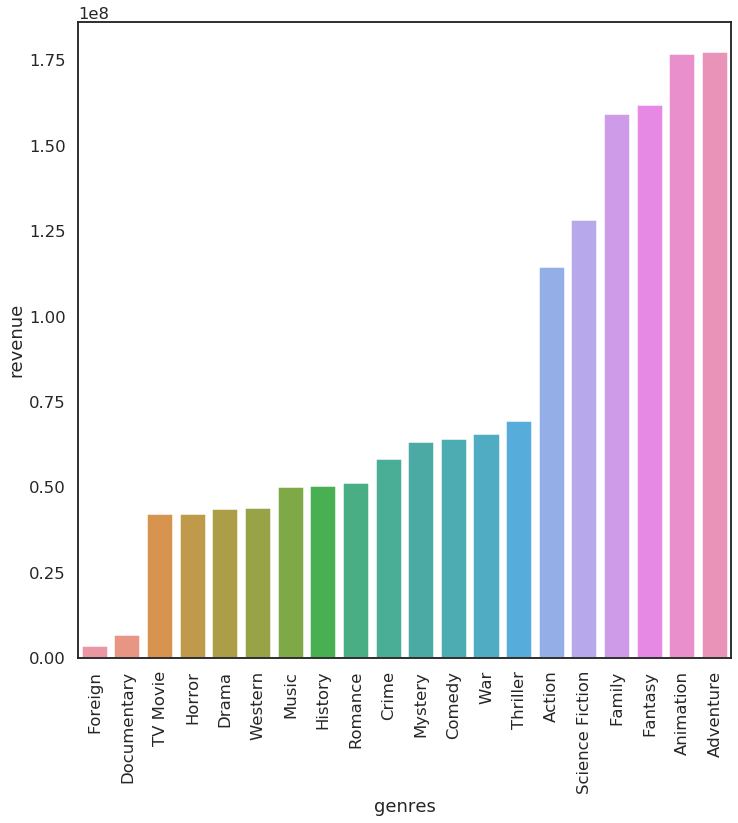

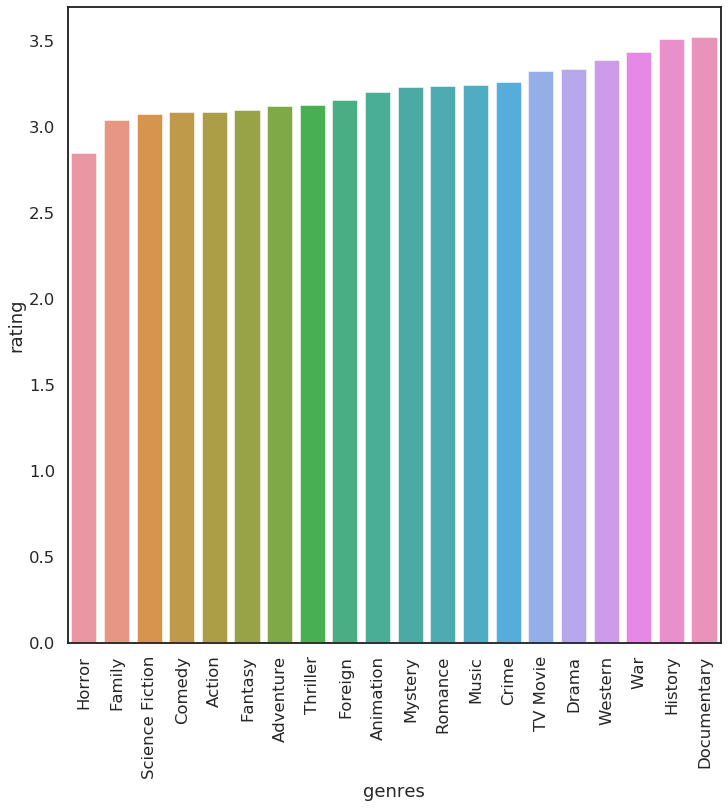

In [4]:
movies_with_revenue = explode(movies_with_revenue_query, ['revenue', 'title'])[['title','genres','revenue', 'rating']]
movies_with_revenue = explode(movies_with_revenue, ['genres'])
movies_with_revenue['rating'] = movies_with_revenue['rating'].apply(lambda x : x[0] if type(x) is list else x)

genres_rating_mean=movies_with_revenue.groupby(['genres'],as_index=False).mean().sort_values(by=['rating'])
genres_revenue_mean=movies_with_revenue.groupby(['genres'],as_index=False).mean().sort_values(by=['revenue'])

chart_revenue=sns.barplot(x=genres_revenue_mean['genres'],y=genres_revenue_mean['revenue'])
chart_revenue.set_xticklabels(labels=genres_revenue_mean['genres'], rotation=90)
plt.show()

chart_revenue=sns.barplot(x=genres_rating_mean['genres'],y=genres_rating_mean['rating'])
chart_revenue.set_xticklabels(labels=genres_rating_mean['genres'], rotation=90)
plt.show()

# Companies revenue and ratings

In [5]:
results = solrcon.search('*:*', fq=['revenue:[1 TO *]', 'production_companies:["" TO *]'], rows=50000)
query_df = pd.DataFrame(results.docs)
print(len(query_df))
movies_with_revenue = explode(query_df, ['revenue', 'title'])[['title','production_companies', 'rating', 'revenue']]
movies_with_revenue = explode(movies_with_revenue, ['production_companies'])
movies_with_revenue['rating'] = movies_with_revenue['rating'].apply(lambda x : x[0] if type(x) is list else x)

companies_raitng_mean=movies_with_revenue.groupby(['production_companies'],as_index=False).mean().sort_values(by=['rating'], ascending=False)
companies_revenue_mean=movies_with_revenue.groupby(['production_companies'],as_index=False).mean().sort_values(by=['revenue'], ascending=False)
companies_movies_counts=movies_with_revenue.groupby(['production_companies'],as_index=False).count().sort_values(by=['title'], ascending=False).head(20)

companies_with_several_movies_ratings = pd.merge(companies_raitng_mean,companies_movies_counts['production_companies'],on='production_companies',how='inner').sort_values(by=['rating'])
companies_with_several_movies_revenue = pd.merge(companies_revenue_mean,companies_movies_counts['production_companies'],on='production_companies',how='inner').sort_values(by=['revenue'])

6968


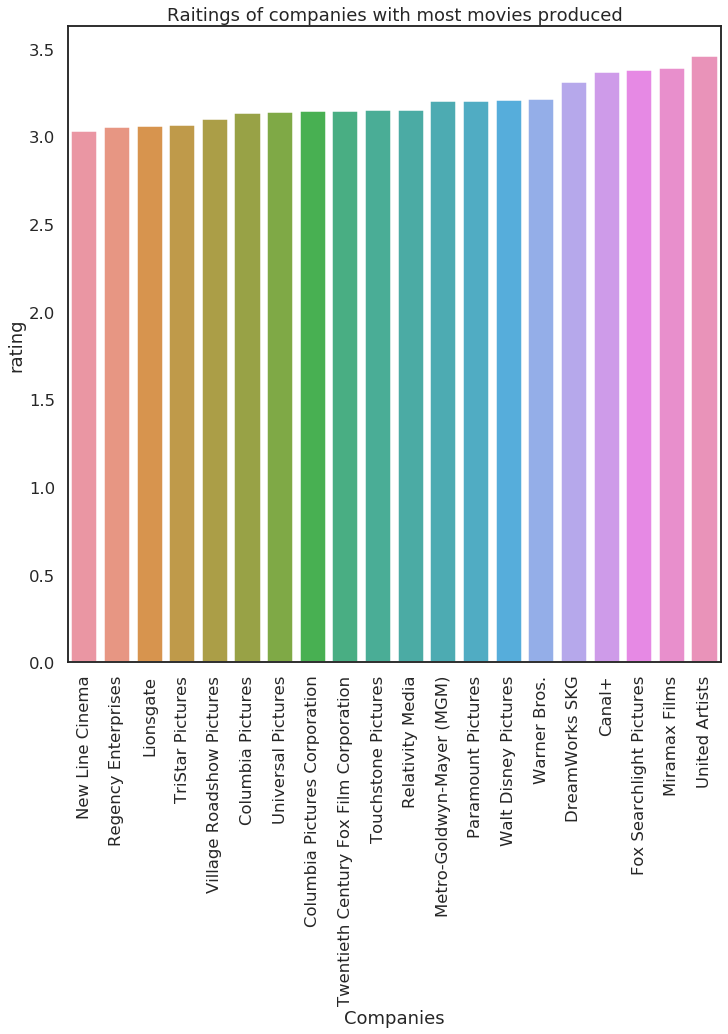

In [6]:
chart_companies_rating=sns.barplot(x=companies_with_several_movies_ratings['production_companies'],y=companies_with_several_movies_ratings['rating'])
chart_companies_rating.set_xticklabels(labels=companies_with_several_movies_ratings['production_companies'], rotation=90)
chart_companies_rating.set_title("Raitings of companies with most movies produced")
chart_companies_rating.set_xlabel("Companies")
plt.show()

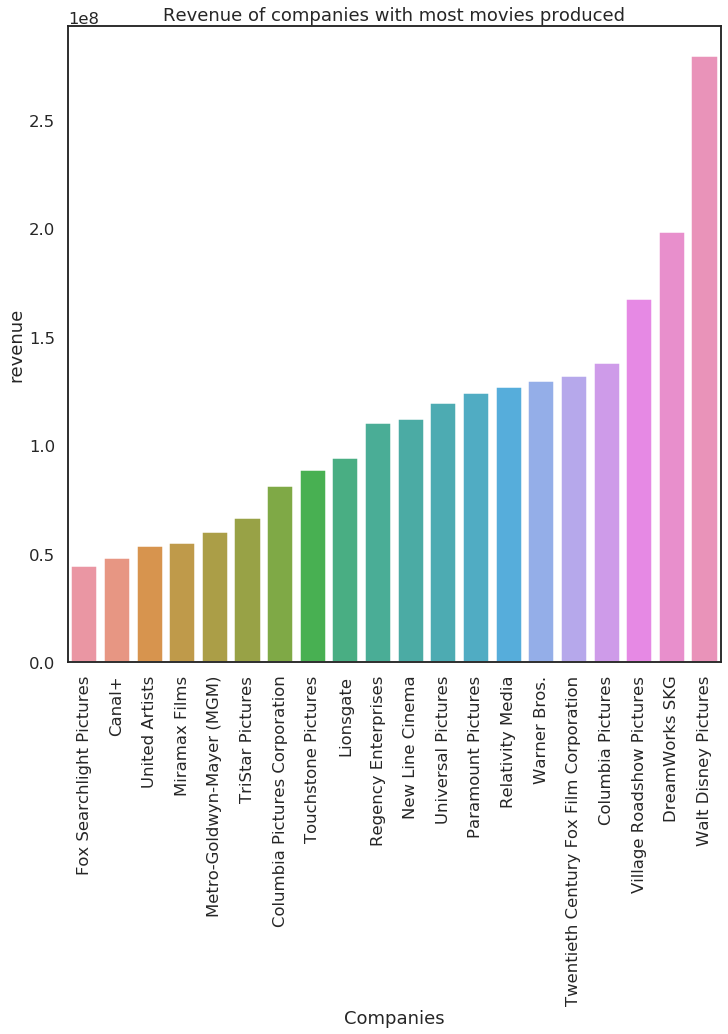

In [7]:
chart_companies_revenue=sns.barplot(x=companies_with_several_movies_revenue['production_companies'],y=companies_with_several_movies_revenue['revenue'])
chart_companies_revenue.set_xticklabels(labels=companies_with_several_movies_revenue['production_companies'], rotation=90)
chart_companies_revenue.set_title("Revenue of companies with most movies produced")
chart_companies_revenue.set_xlabel("Companies")
plt.show()

# Heatmaps

In [8]:
results = solrcon.search('*:*', fq=['revenue:[1 TO *]', 'production_companies:["" TO *]', 'genres:["" TO *]'], rows=50000)
query_df = pd.DataFrame(results.docs)
print(len(query_df))

6965


In [9]:
movies_with_revenue = explode(query_df, ['revenue', 'title'])[['title','production_companies', 'rating', 'revenue', 'genres']]
movies_with_revenue = explode(movies_with_revenue, ['production_companies'])
movies_with_revenue = explode(movies_with_revenue, ['genres'])
movies_with_revenue['rating'] = movies_with_revenue['rating'].apply(lambda x : x[0] if type(x) is list else x)

companies_and_genres_with_revenue = movies_with_revenue[['production_companies', 'genres', 'revenue']].groupby(['production_companies', 'genres'],as_index=False).mean().sort_values(by=['revenue'], ascending=False)
companies_and_genres_with_revenue = pd.merge(companies_and_genres_with_revenue,companies_with_several_movies_revenue['production_companies'].head(20),on='production_companies',how='inner').sort_values(by=['revenue'])

companies_and_genres_with_rating = movies_with_revenue[['production_companies', 'genres', 'rating']].groupby(['production_companies', 'genres'],as_index=False).mean().sort_values(by=['rating'], ascending=False)
companies_and_genres_with_rating = pd.merge(companies_and_genres_with_rating,companies_with_several_movies_ratings['production_companies'].head(20),on='production_companies',how='inner').sort_values(by=['rating'])


### Revenue of companies per genre

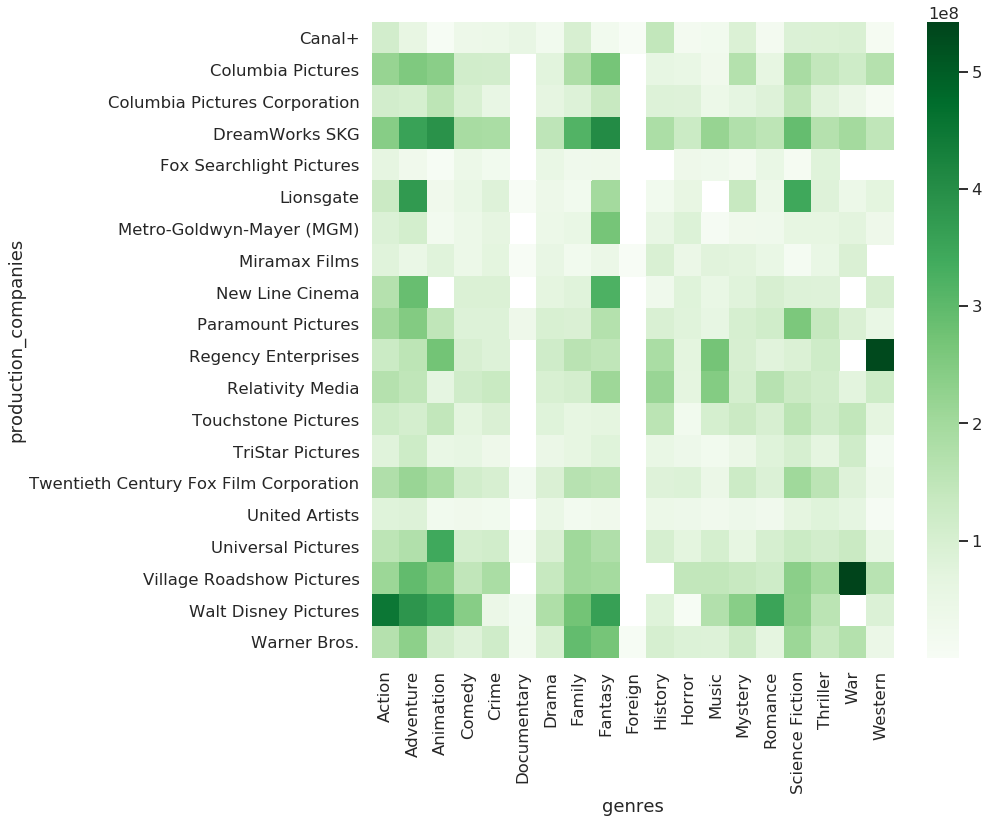

In [10]:
companies_and_genres_with_revenue = companies_and_genres_with_revenue.pivot("production_companies", "genres", "revenue")
ax = sns.heatmap(companies_and_genres_with_revenue, xticklabels=True, yticklabels=True, cmap="Greens")

### Ratings of companies per genre

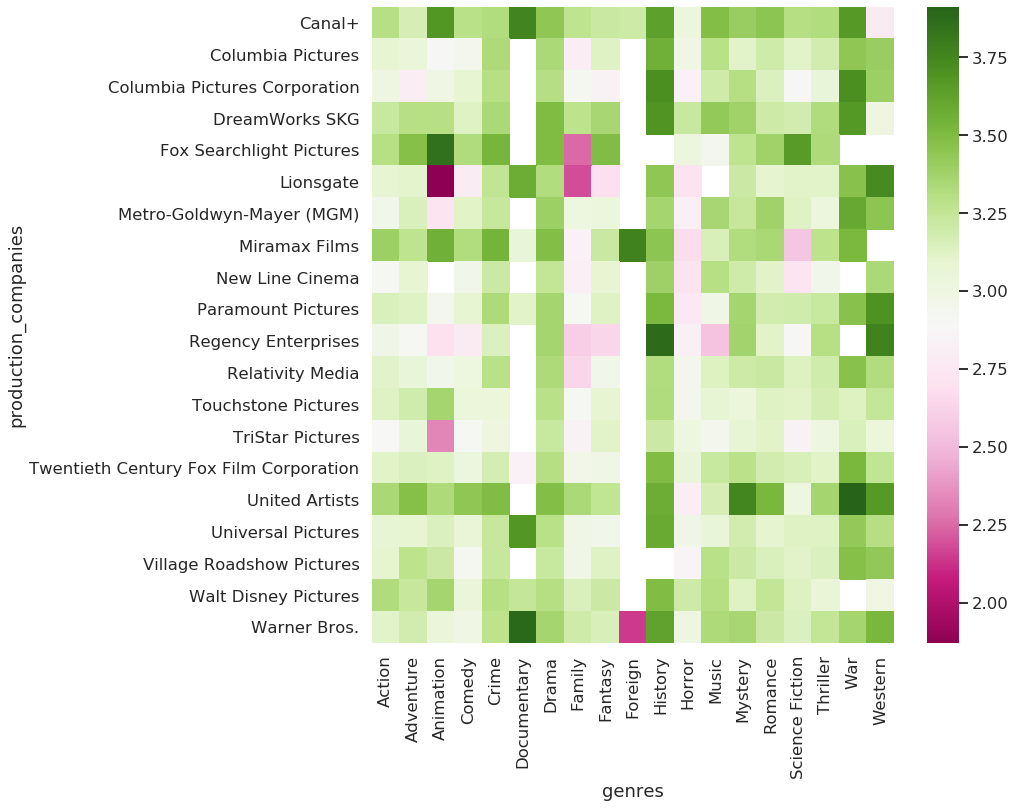

In [11]:
companies_and_genres_with_rating = companies_and_genres_with_rating.pivot("production_companies", "genres", "rating")
ax = sns.heatmap(companies_and_genres_with_rating, xticklabels=True, yticklabels=True, cmap="PiYG")